In [17]:
import numpy as np
from enum import Enum

class Kernel(Enum):
    POLYNOMIAL_KERNEL = "polynomial",
    GAUSSIAN_KERNEL = "gaussian",
    SIGMOID_KERNEL = "sigmoid",
    NONE = "none"# add mode kernels here

class SVM:
    def __init__(self, C = 1.0, kernel: Kernel = Kernel.NONE, degree: int = 2, homogenous: bool = False, sigma: float = 1.0, k: float = 1.0, delta: float = 0.0) -> None:
        self.C = C # regularization parameter
        self.kernel = kernel # kernel function
        self.degree = degree
        self.homogenous = homogenous
        self.sigma = sigma
        self.k = k
        self.delta = delta

    def computeDotProduct(self, w: np.array, b: float, x: np.array, y: float) -> float:
        return 1 - y * self.computePrediction(w,b,x)

    def computePrediction(self, w: np.array, b: float, x: np.array) -> float:
        return np.dot(w,x.T) + b
    
    def polynomialKernel(self, x1: np.array, x2: np.array) -> float: 
        coef = 1 if self.homogenous else 0
        return (coef + x1.dot(x2)) ** self.degree

    def gaussianKernel(self, x1: np.array, x2: np.array) -> float:
        return np.exp(-np.linalg.norm(x1-x2)**2 / (2 * (self.sigma ** 2)))
    
    def sigmoidKernel(self, x1: np.array, x2: np.array) -> float:
        return np.tanh(self.k * x1.dot(x2) - self.delta)
    
    def kernelToValue(self, kernel: Kernel, x1: np.array, x2: np.array) -> float:
        if kernel == Kernel.POLYNOMIAL_KERNEL:
            return self.polynomialKernel(x1,x2)
        elif kernel == Kernel.GAUSSIAN_KERNEL:
            return self.gaussianKernel(x1,x2)
        elif kernel == Kernel.SIGMOID_KERNEL:
            return self.sigmoidKernel(x1,x2)
        else:
            raise Exception("Kernel not implemented")

    def hingeloss(self, w: np.array, b: float, x: np.ndarray, y: np.array) -> float:
        # check if the dimensions are correct
        regularizer: float = 0.5 * np.linalg.norm(w) ** 2
        loss: float = regularizer
        for i in range(x.shape[0]):
            optimizationTerm: float = self.computeDotProduct(w,b,x[i],y[i]) # since the w and x are vectors, horizontal ones, we need to transpose x
            loss += self.C * max(0,optimizationTerm)
        return loss
    
    def updateX(self, X: np.ndarray, l: np.ndarray, kernel: Kernel) -> np.ndarray:
        modifiedX = np.zeros((X.shape[0],l.shape[0]))
        for i in range(X.shape[0]):
            for j in range(l.shape[0]):
                modifiedX[i][j] = self.kernelToValue(kernel,X[i],l[j])
        
        return modifiedX

    def __fit(self, X: np.ndarray, Y: np.ndarray, batchSize: int = 100, learningRate: float = 0.001, epochs: int = 1000) -> (np.array, float,  list):
        if self.kernel != Kernel.NONE:
            self.l = np.copy(X)
            X = self.updateX(X, self.l, self.kernel)  
        
        numberOfFeatures: int = X.shape[1]
        numberOfSamples: int = X.shape[0]
        ids = np.arange(numberOfSamples) # ids of the samples
        np.random.shuffle(ids) # shuffle the ids
        w: np.array = np.zeros((1,numberOfFeatures))[0]
        b: float = 0
        losses: list = []

        for _ in range(epochs):
            loss = self.hingeloss(w,b,X,Y)
            losses.append(loss)

            for batchInitial in range(0,numberOfSamples,batchSize):
                gradW: float = 0
                gradB: float = 0
                for j in range (batchInitial, batchInitial + batchSize):
                    if j < numberOfSamples:
                        optimizationTerm: float = self.computeDotProduct(w,b,X[ids[j]],Y[ids[j]])
                        if optimizationTerm > 0:
                            gradW += self.C * Y[ids[j]] * X[ids[j]]
                            gradB += self.C * Y[ids[j]]
                w = w - learningRate * w + learningRate * gradW
                b = b + learningRate * gradB
        return w,b,losses

    def fit(self, X: np.ndarray, Y: np.ndarray, batchSize: int = 100, learningRate: float = 0.001, epochs: int = 1000) -> (np.array, float,  list):
        classes: int = len(np.unique(Y))
        if self.kernel != Kernel.NONE:
            w: np.array = np.zeros((classes,X.shape[0]))
        else:
            w: np.array = np.zeros((classes,X.shape[1]))
        b: np.array = np.zeros(classes)
        losses: list = []

        if classes == 2:
            yTemp = np.copy(Y)
            yTemp[yTemp != 1] = -1
            yTemp[yTemp == 1] = 1
            w, b, loss = self.__fit(X,yTemp,batchSize=batchSize,learningRate=learningRate,epochs=epochs)
            losses.append(loss)
            return w,b,losses
        
        for i in range(classes):
            print(i+1,"'th class out of ", classes)
            yTemp = np.copy(Y)
            yTemp[yTemp != i] = -1
            yTemp[yTemp == i] = 1
            w[i], b[i], loss = self.__fit(X,yTemp,batchSize=batchSize,learningRate=learningRate,epochs=epochs)
            losses.append(loss)

        return w,b, losses

    def predict(self, X: np.ndarray, w: np.ndarray, b: float) -> np.array:
        if self.kernel != Kernel.NONE:
            X = self.updateX(X, self.l, self.kernel)
        if w.ndim > 1:
            prediction = np.matmul(X,w.T) +b 
            return np.argmax(prediction,axis=1)
        else:
            prediction = self.computePrediction(w,b,X)
            return np.sign(prediction)
        
    def accuracy(self, X: np.ndarray, Y: np.ndarray, w: np.ndarray, b: float) -> float:
        predictions = self.predict(X,w,b)
        return np.mean(predictions == Y)
    
    def printStatistics(self, X: np.ndarray, Y: np.ndarray, w: np.array, b: np.array, loss: list) -> None:
        print("Accuracy: ", self.accuracy(X,Y,w,b))
        print("Loss: ", loss)
        print("predict:", self.predict(X,w,b))
        print("w:", w)
        print("b: ", b)
        

$$\min {\frac {1}{2} \|w\|^2} + C_i \cdot \sum_{i=1}^n \max{\{0,1-y_n(w^Tx+b)\}}$$

In [18]:
svm = SVM()
# print(SVM.hingeloss(np.array([1,2]),1,np.array([[1,2],[3,4],[5,6]]),np.array([1,-1,1])))
w, b, losses = svm.fit(np.array([[1,2],[3,4],[5,6]]),np.array([1,-1,1]))
print(w,b,losses)
print(svm.predict(np.array([[1,2],[3,4],[5,6]]),w,b))

svm = SVM(kernel=Kernel.POLYNOMIAL_KERNEL)
w, b, losses = svm.fit(np.array([[1,2,3],[3,4,3]]),np.array([1,-1]))
print(w,b,losses)
print(svm.predict(np.array([[1,2,3],[3,4,5],[5,6,5]]),w,b))

[-0.07281361  0.16554549] 0.3840000000000003 [[3.0, 2.9740124999999997, 2.9480749500125, 2.922187250187425, 2.8963493008743004, 2.8705610026218524, 2.8448222561776118, 2.8191329624875126, 2.7934930226955004, 2.7679023381431316, 2.742360810369183, 2.7168683411092553, 2.691424832295378, 2.66603018605562, 2.6406843047136945, 2.6153870907885715, 2.590138446994086, 2.5649382762385446, 2.5397864816243434, 2.5146829664475767, 2.4896276341976478, 2.4646203885568863, 2.439661133400161, 2.414749772794494, 2.3898862109986783, 2.365070352462892, 2.3677279213347853, 2.3589968332200373, 2.3688372292571565, 2.3645499729598516, 2.3583282047632492, 2.3700959694497827, 2.3613601476068524, 2.3621092974489306, 2.3669109276949634, 2.358181472750501, 2.3658776486023445, 2.3637370157475326, 2.3553693151158743, 2.369285407601799, 2.360551206072003, 2.3591518606807713, 2.3661043680380343, 2.357376525406326, 2.362921650926208, 2.3629344368730316, 2.3542129309337225, 2.3666787146356807, 2.35977557138958, 2.35615

In [51]:
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Creating dataset
X, y = datasets.make_blobs(
        n_samples = 100, # Number of samples
        n_features = 2, # Features
        centers = 2,
        cluster_std = 1,
        # random_state=25
    )

# Classes 1 and -1
y = np.where(y == 0, -1, 1)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

svm = SVM()

w, b, losses = svm.fit(X_train, y_train)

loss = losses.pop()

svm.printStatistics(X_test,y_test, w,b,loss)
# print("X_test", X_test)
# print("y_test", y_test)

Accuracy:  1.0
Loss:  [50.0, 31.331920086852378, 15.327125860952506, 14.09323291401023, 26.21776866114171, 8.814731078016019, 7.970037247833197, 5.083813109550158, 4.26102815480977, 1.4414578820699346, 1.3874832904309662, 1.340496323663908, 1.309850563156485, 1.2561390545480242, 1.202534915245273, 1.1957620533950803, 1.4103499434793896, 1.81850251586422, 1.5492738044522385, 1.2805752852343697, 1.056156885778241, 1.1189862125954744, 1.1519366386794756, 1.042224714108342, 1.1575908922803393, 1.0103911292098884, 1.0090610007894143, 1.0077335312956532, 1.0064087154134107, 1.0050865478381164, 1.0037670232758047, 1.0024501364430933, 1.0011358820671605, 0.9998242548857253, 0.9985152496470255, 0.9972088611097985, 0.9962016379768889, 0.996855483482031, 0.9955524128173677, 0.9942519469909629, 0.9929540807957447, 0.991658809035051, 0.9903661265226069, 0.9890760280825054, 0.9877885085491857, 0.9865035627674127, 0.9852211855922578, 0.9839413718890758, 0.9826641165334865, 0.9813894144113527, 0.98011

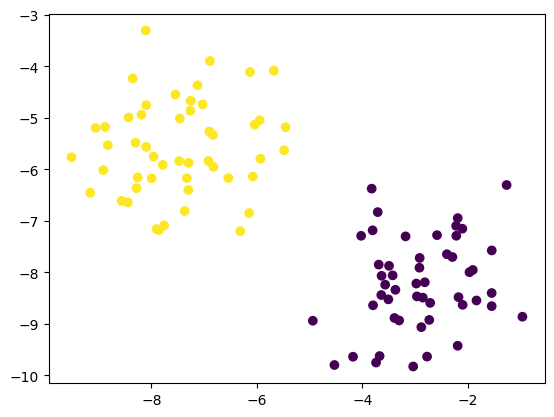

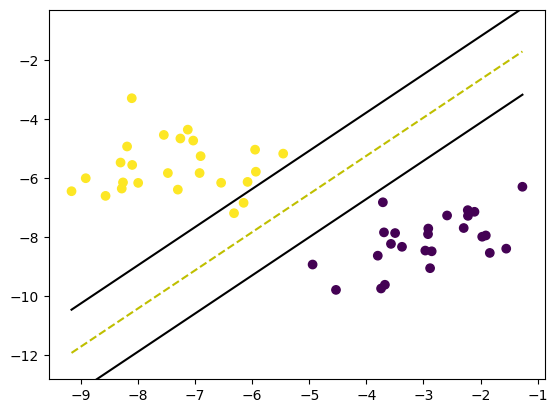

In [53]:
# Visualizing the scatter plot of the dataset
def visualize_dataset(X: np.ndarray = X, y: np.ndarray = y):
    plt.scatter(X[:, 0], X[:, 1], c=y)


# Visualizing SVM
def visualize_svm(w: np.array,b: float, X: np.ndarray, XTest: np.ndarray, yTest: np.ndarray):
    # split w to w and b where b is first element of w
    # b = w[0]
    # w = w[1:] 

    def get_hyperplane_value(x, w, b, offset):
        return (-w[0] * x + b + offset) / w[1]

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    plt.scatter(XTest[:, 0], XTest[:, 1], marker="o", c=yTest)

    x0_1 = np.amin(XTest[:, 0])
    x0_2 = np.amax(XTest[:, 0])

    x1_1 = get_hyperplane_value(x0_1, w, b, 0)
    x1_2 = get_hyperplane_value(x0_2, w, b, 0)

    x1_1_m = get_hyperplane_value(x0_1, w, b, -1)
    x1_2_m = get_hyperplane_value(x0_2, w, b, -1)

    x1_1_p = get_hyperplane_value(x0_1, w, b, 1)
    x1_2_p = get_hyperplane_value(x0_2, w, b, 1)

    ax.plot([x0_1, x0_2], [x1_1, x1_2], "y--")
    ax.plot([x0_1, x0_2], [x1_1_m, x1_2_m], "k")
    ax.plot([x0_1, x0_2], [x1_1_p, x1_2_p], "k")

    x1_min = np.amin(X[:, 1])
    x1_max = np.amax(X[:, 1])
    ax.set_ylim([x1_min - 3, x1_max + 3])

    plt.show()


visualize_dataset(X, y)
visualize_svm(w, b, X, X_test, y_test)

Kernels

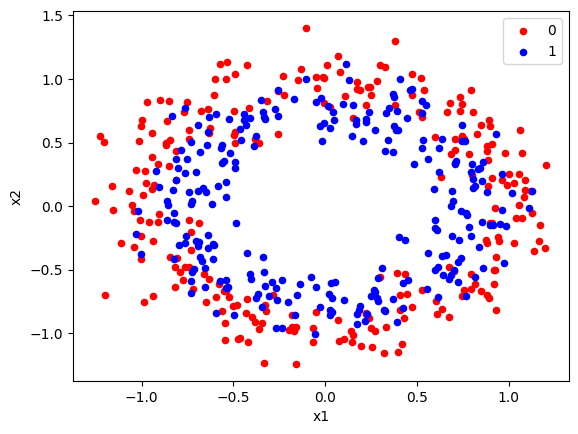

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=500, noise=0.13, random_state=42)

df = pd.DataFrame(dict(x1=X[:, 0], x2=X[:, 1], y=y))

colors = {0:'red', 1:'blue'}
fig, ax = plt.subplots()
grouped = df.groupby('y')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x1', y='x2', label=key, color = colors[key])
plt.show()

In [7]:
y[y == 0] = -1 # change to -1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm = SVM()

w, b, losses = svm.fit(X_train, y_train)

# Loss value
loss = losses.pop()

svm.printStatistics(X_test,y_test,w,b,loss)

Accuracy:  0.46
Loss:  [350.0, 349.99305740101585, 349.9861494162361, 349.97927585252154, 349.97243651794, 349.9656312217608, 349.95885977444595, 349.952121987641, 349.9454176741688, 349.938746648019, 349.93210872434145, 349.92550371943884, 349.91893145075676, 349.91239173687796, 349.90588439751406, 349.8994092534962, 349.89296612677003, 349.88655484038554, 349.8801752184916, 349.8738270863265, 349.86751027021234, 349.8612245975475, 349.8549698967965, 349.8487459974864, 349.8425527301979, 349.83638992655824, 349.8302574192327, 349.8241550419208, 349.8180826293468, 349.81204001725274, 349.80602704239266, 349.800043542525, 349.7940893564056, 349.7881643237819, 349.78226828538465, 349.776401082924, 349.7705625590788, 349.76475255749307, 349.7589709227691, 349.7532175004607, 349.7474921370653, 349.74179468001995, 349.7361249776942, 349.7304828793818, 349.72486823529823, 349.7192808965707, 349.7137207152347, 349.7081875442258, 349.702681237376, 349.6972016494053, 349.6917486359174, 349.6863

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
svm = SVM(kernel=Kernel.GAUSSIAN_KERNEL)

w, b, losses = svm.fit(X_train, y_train)
loss = losses.pop()

svm.printStatistics(X_test,y_test,w,b,loss)

Accuracy:  0.7266666666666667
Loss:  [350.0, 363.93688784344994, 376.4027050237964, 334.26867726084845, 350.0406787777271, 340.44725209504577, 359.05873018663823, 352.0613365657524, 343.6791539067905, 337.8705444697747, 346.23886587674764, 376.39849127363175, 325.7385535953205, 341.55510522473384, 337.77799613542265, 322.780050516865, 341.8359378993166, 322.4810944033104, 338.3153004629784, 317.25512944629384, 333.1106883321495, 316.69402243834986, 332.6045894355454, 341.2015857146541, 335.4434333704576, 314.8572089828906, 310.7685700119912, 326.783744847143, 326.16421186674705, 316.8475376354602, 319.3750971098178, 312.10400067937593, 327.7067703484599, 319.3252148459463, 305.2166216873574, 316.98613694165823, 301.8381106076609, 314.5184099223757, 295.491567380678, 314.88856660415445, 307.679559507066, 306.9324171607984, 303.8939211815672, 303.80498054195755, 302.1453220814175, 301.0536941414802, 298.3526652540869, 295.947701522485, 296.5862138671766, 294.60322187631584, 305.278319421

In [9]:
import plotly.express as px

df['x1^2'] = df['x1'] ** 2
df['x2^2'] = df['x2'] ** 2
df['x1 * x2'] = df['x1'] * df['x2']
df['x1^2 + x2^2'] = df['x1'] ** 2 + df['x2'] **2

fig = px.scatter_3d(df, x='x1', y='x2', z='x1 * x2', color='y')
fig.show()

In [10]:
fig = px.scatter_3d(df, x='x1^2', y='x2^2', z='x1 * x2', color='y')
fig.show()

In [11]:
fig = px.scatter_3d(df, x='x1', y='x2', z='x1^2 + x2^2', color='y')
fig.show()

In [12]:
# lets imagine we want to classify n classes from a data set
# we can use one vs rest method
# basically we will train n different classifiers, one for each class

from sklearn.datasets import load_iris

iris = load_iris()
X = iris.data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm = SVM(kernel=Kernel.GAUSSIAN_KERNEL)
w,b,losses = svm.fit(X_train,y_train)

svm.printStatistics(X_test,y_test,w,b,losses.pop())
print(losses)


1 'th class out of  3
2 'th class out of  3
3 'th class out of  3
Accuracy:  1.0
Loss:  [105.0, 71.62428196801957, 47.9106075723313, 37.010655764218036, 29.50816332407204, 25.28867496135696, 24.418547310275102, 23.6615172411884, 23.148521020263424, 22.663249412274276, 22.299097608699583, 21.986354961357318, 21.713772887438097, 21.446737993526977, 21.188537295639993, 20.963550372725987, 20.747950964196963, 20.594886397447603, 20.395339709157458, 20.165554189500746, 20.04780349227253, 19.891975941797725, 19.749150019113266, 19.61976015857954, 19.50087935445963, 19.360349461674943, 19.246149221981707, 19.11608470892284, 18.982480567507984, 18.857675134390522, 18.73543833131899, 18.61433134679308, 18.49611747576783, 18.363438209396936, 18.23973955753928, 18.119956328092155, 17.999995995546136, 17.877360127369943, 17.75700376118405, 17.63493186753472, 17.51336473951668, 17.396118116265267, 17.277862846038666, 17.15733758476934, 17.037475440485522, 16.919530768334933, 16.81763178690942, 16.7

In [13]:
# lets imagine we want to classify n classes from a data set
# we can use one vs rest method
# basically we will train n different classifiers, one for each class

from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler

iris = load_digits()
X = iris.data
y = iris.target
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
# fit_transform use to do some calculation and then do transformation

# X_train = scaler.fit_transform(X_train)  # data normalization
# X_test = scaler.transform(X_test)

# svm = SVM(kernel=Kernel.POLYNOMIAL_KERNEL, degree=3)
svm = SVM(kernel=Kernel.NONE)
w,b,losses = svm.fit(X_train,y_train)

svm.printStatistics(X_test,y_test,w,b,losses.pop())
print(losses)

(1797, 64)
1 'th class out of  10
2 'th class out of  10
3 'th class out of  10
4 'th class out of  10
5 'th class out of  10
6 'th class out of  10
7 'th class out of  10
8 'th class out of  10
9 'th class out of  10
10 'th class out of  10
Accuracy:  0.9648148148148148
Loss:  [1257.0, 4326.8470987104565, 321.28327635162583, 178.63823787425883, 170.3904722107718, 149.30426933451227, 187.91655834112467, 93.7230888018778, 185.43276097169266, 111.88759104918813, 170.93730935157836, 102.88953787452974, 141.9528857806452, 233.39286772121542, 77.56770579851388, 97.96550003449373, 102.19680220563627, 204.51743743357426, 138.9903758377765, 63.86302053377729, 105.56657434209889, 177.04089846503123, 120.56988175021964, 75.99000073594559, 111.24703701959943, 159.33126901068044, 155.59064386674098, 194.68228236757992, 271.42697702681505, 144.87187612940957, 158.31071504825803, 121.29396212546722, 213.29165595086096, 55.11668465340082, 163.32686624705642, 306.33968626102256, 167.7034943796471, 119

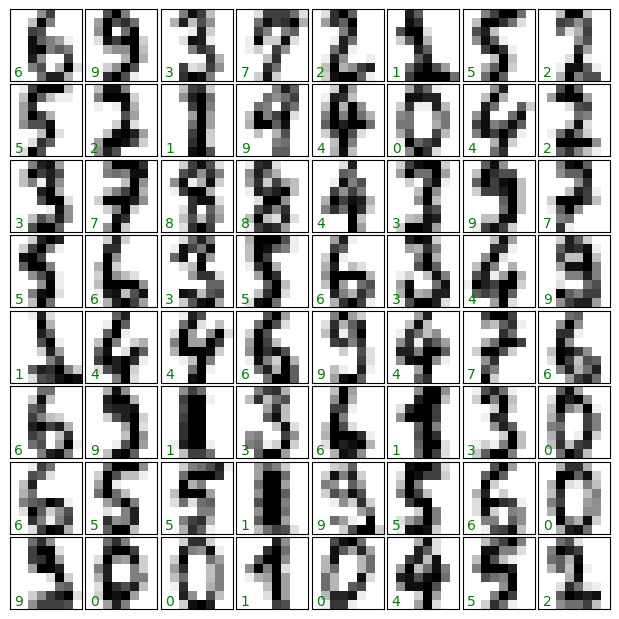

In [14]:
predicted = svm.predict(X_test,w,b)

fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(X_test.reshape(-1, 8, 8)[i], cmap=plt.cm.binary,
              interpolation='nearest')

    # label the image with the target value
    if predicted[i] == y_test[i]:
        ax.text(0, 7, str(predicted[i]), color='green')
    else:
        ax.text(0, 7, str(predicted[i]), color='red')